# JFK Documents Analysis Workflow (March 2025 Release)
This notebook demonstrates an end-to-end pipeline for processing the newly declassified JFK documents:

Fetch - Retrieve the March 2025 document release from government archives

Parse - Extract text using Mistral OCR for document digitization

Structure - Clean and organize historical records for analysis

Index - Store embeddings in Pinecone vector database

Query - Enable lexical search capabilities through indexed documents



## Install Packages

In [ ]:
pip install mistralai pinecone

## Fetch File List

In [3]:
import requests
from bs4 import BeautifulSoup

def fetch_html(url):
    """Fetches the HTML source code for a given URL.

    Args:
        url: The URL to fetch.

    Returns:
        The HTML source code as a string, or None if there was an error.
    """
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for bad status codes (4xx or 5xx)
        return response.text
    except requests.exceptions.RequestException as e:
        print(f"Error fetching URL: {e}")
        return None

def save_to_file(content, filename):
    """Saves content to a file.

    Args:
        content: The content to save.
        filename: The name of the file to save to.
    """
    try:
        with open(filename, 'w', encoding='utf-8') as file:
            file.write(content)
        print(f"Successfully saved content to {filename}")
    except Exception as e:
        print(f"Error saving to file: {e}")

def extract_pdf_filenames(html_content):
    """Extracts PDF filenames from HTML content.

    Args:
        html_content: The HTML content to parse.

    Returns:
        A list of PDF filenames.
    """
    soup = BeautifulSoup(html_content, 'html.parser')

    # Find all <td> elements
    td_elements = soup.find_all('td')

    # Extract PDF filenames from <a> tags within <td> elements
    pdf_filenames = []
    for td in td_elements:
        a_tag = td.find('a', href=True)
        if a_tag and a_tag['href'].endswith('.pdf'):  # Only keep links ending in .pdf
            filename = a_tag['href'].split('/')[-1]
            pdf_filenames.append(filename)

    return pdf_filenames

def main():
    # URL to fetch
    url = "https://www.archives.gov/research/jfk/release-2025"

    # Either fetch from URL or read from local file
    try:
        # Try to read from local file first
        with open('source.html', 'r', encoding='utf-8') as file:
            html_content = file.read()
        print("Successfully read from source.html")
    except FileNotFoundError:
        # If file doesn't exist, fetch from URL
        print("Local file not found. Fetching from URL...")
        html_content = fetch_html(url)
        if html_content:
            # Save the fetched content to a file for future use
            save_to_file(html_content, 'source.html')
        else:
            print("Failed to fetch content from URL")
            return

    # Extract PDF filenames
    pdf_filenames = extract_pdf_filenames(html_content)

    # Check if any filenames were found
    if not pdf_filenames:
        print("Error: No PDF filenames found in the HTML content")
        return

    # Save the filenames to a text file
    with open('jfk_pdf_filenames.txt', 'w') as f:
        for filename in pdf_filenames:
            f.write(filename + '\n')

    print(f"Extracted {len(pdf_filenames)} PDF filenames and saved to 'jfk_pdf_filenames.txt'")

    # Print the first few filenames to verify
    print("Sample filenames:")
    for filename in pdf_filenames[:5]:
        print(filename)

if __name__ == "__main__":
    main()

Local file not found. Fetching from URL...
Successfully saved content to source.html
Extracted 2182 PDF filenames and saved to 'jfk_pdf_filenames.txt'
Sample filenames:
104-10003-10041.pdf
104-10004-10143 (C06932208).pdf
104-10004-10143.pdf
104-10004-10156.pdf
104-10004-10213.pdf


## Fetch PDFs

In [ ]:
import requests
import os

# Base URL for PDFs (derived from the sample PDF URL)
base_url = "https://www.archives.gov/files/research/jfk/releases/2025/0318/"

# Folder to save PDFs
output_folder = "jfk_pdfs"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"Created folder: {output_folder}")

# Read the list of PDF filenames from the text file
try:
    with open('jfk_pdf_filenames.txt', 'r') as f:
        pdf_filenames = [line.strip() for line in f if line.strip()]
    print(f"Loaded {len(pdf_filenames)} filenames from jfk_pdf_filenames.txt")
except FileNotFoundError:
    print("Error: jfk_pdf_filenames.txt not found")
    exit()

# Fetch and save each PDF
for filename in pdf_filenames:
    full_url = base_url + filename
    output_path = os.path.join(output_folder, filename)

    print(f"Fetching {filename} from {full_url}")
    try:
        response = requests.get(full_url, timeout=10)  # 10-second timeout
        response.raise_for_status()  # Raise an error for bad status codes

        with open(output_path, 'wb') as pdf_file:
            pdf_file.write(response.content)
        print(f"Saved {filename} to {output_path}")

    except requests.exceptions.RequestException as e:
        print(f"Failed to fetch {filename}: {e}")

print(f"Finished downloading {len(pdf_filenames)} PDFs to {output_folder}")

## Parse PDFs with Mistral OCR

We will use Mistral OCR to parse our PDFs. Mistral will return JSON files, which we can then use to construct:

-> Markdown files (including images)

-> Text files (without images)

Note: Mistral does offer a batch option, but it's only available on their paid plan. This exercise uses the basic single-PDF flow in a for loop, so this step can take 2-3 hours to complete.

In [20]:
# Set your Mistral API key
# https://console.mistral.ai/home

api_key = "YOUR_MISTRAL_API_KEY"

# Initialize Mistral client
client = Mistral(api_key=api_key)

In [21]:
import os
import json
import glob
import re
import time
from mistralai import Mistral
from mistralai.models import OCRResponse
from IPython.display import Markdown, display

# Set up directories
input_dir = 'jfk_pdfs'  # Local directory containing PDFs
output_dir = 'ocr_results'  # Base output directory
json_dir = os.path.join(output_dir, 'json')  # Subdirectory for JSON files
md_dir = os.path.join(output_dir, 'markdown')  # Subdirectory for Markdown files
txt_dir = os.path.join(output_dir, 'text')  # Subdirectory for text files

# Create output subdirectories if they don't exist
os.makedirs(json_dir, exist_ok=True)
os.makedirs(md_dir, exist_ok=True)
os.makedirs(txt_dir, exist_ok=True)

def replace_images_in_markdown(markdown_str: str, images_dict: dict) -> str:
    """
    Replace image placeholders in markdown with base64-encoded images.
    """
    for img_name, base64_str in images_dict.items():
        markdown_str = markdown_str.replace(
            f"![{img_name}]({img_name})", f"![{img_name}]({base64_str})"
        )
    return markdown_str

def clean_markdown_text(markdown: str) -> str:
    """
    Clean markdown text by removing image references and formatting.

    Args:
        markdown: The markdown text to clean

    Returns:
        Cleaned text
    """
    # Remove image markdown syntax: ![img-0.jpeg](img-0.jpeg)
    cleaned = re.sub(r'!\[.*?\]\(.*?\)', '', markdown)

    # Remove link markdown syntax: [text](link)
    cleaned = re.sub(r'\[.*?\]\(.*?\)', '', cleaned)

    # Remove specific image references like img-0.jpeg
    cleaned = re.sub(r'img-\d+\.jpeg', '', cleaned)

    # Clean up excessive whitespace
    cleaned = re.sub(r'\n\s*\n', '\n\n', cleaned)

    return cleaned.strip()

def save_json_result(ocr_response: OCRResponse, output_file: str):
    """Save OCR response as JSON file."""
    with open(output_file, 'w') as f:
        json.dump(ocr_response.model_dump(), f, indent=2)

def save_markdown_result(ocr_response: OCRResponse, output_file: str):
    """Save OCR response as Markdown file with embedded images."""
    markdowns = []
    for page in ocr_response.pages:
        image_data = {img.id: img.image_base64 for img in page.images}
        markdowns.append(replace_images_in_markdown(page.markdown, image_data))

    with open(output_file, 'w') as f:
        f.write("\n\n".join(markdowns))

def save_text_result(ocr_response: OCRResponse, output_file: str):
    """
    Save clean text content extracted from OCR response.
    Removes image references and cleans up formatting.
    """
    cleaned_text = []

    for page in ocr_response.pages:
        if hasattr(page, 'markdown'):
            cleaned_page = clean_markdown_text(page.markdown)
            if cleaned_page:  # Only add non-empty pages
                cleaned_text.append(cleaned_page)

    # Combine cleaned pages with double newlines
    final_text = "\n\n".join(cleaned_text)

    # Write to file
    with open(output_file, 'w') as f:
        f.write(final_text)

def process_pdf(pdf_path):
    """
    Process a single PDF file with Mistral OCR and save results in separate folders
    """
    print(f"Processing: {pdf_path}")
    filename = os.path.basename(pdf_path)
    base_name = os.path.splitext(filename)[0]

    try:
        # Upload PDF
        print("Uploading PDF to Mistral...")
        uploaded_pdf = client.files.upload(
            file={
                "file_name": filename,
                "content": open(pdf_path, "rb"),
            },
            purpose="ocr"
        )

        print(f"Uploaded file ID: {uploaded_pdf.id}")

        # Get signed URL
        print("Getting signed URL...")
        signed_url = client.files.get_signed_url(file_id=uploaded_pdf.id)

        # Process with OCR
        print("Processing with OCR...")
        ocr_response = client.ocr.process(
            model="mistral-ocr-latest",
            document={
                "type": "document_url",
                "document_url": signed_url.url,
            },
            include_image_base64=True
        )

        # Define output files in separate folders
        json_file = os.path.join(json_dir, f"{base_name}.json")
        md_file = os.path.join(md_dir, f"{base_name}.md")
        txt_file = os.path.join(txt_dir, f"{base_name}.txt")

        # Save results
        save_json_result(ocr_response, json_file)
        print(f"JSON results saved to: {json_file}")

        save_markdown_result(ocr_response, md_file)
        print(f"Markdown results saved to: {md_file}")

        save_text_result(ocr_response, txt_file)
        print(f"Clean text results saved to: {txt_file}")

        return ocr_response

    except Exception as e:
        print(f"Error processing {filename}: {str(e)}")
        return None

# Find and process PDFs
def main():
    pdf_files = glob.glob(os.path.join(input_dir, "*.pdf"))

    if not pdf_files:
        print(f"No PDF files found in {input_dir}")
    else:
        print(f"Found {len(pdf_files)} PDF files")

        # Process first PDF for testing
        process_single = input("Process a single PDF for testing? (y/n): ").lower().strip()

        if process_single == 'y':
            first_pdf = pdf_files[0]
            print(f"Processing first PDF: {first_pdf}")
            result = process_pdf(first_pdf)
            print("\nTest complete. Check the output subdirectories for results:")
        else:
            print("\nProcessing all PDFs:")
            for pdf_file in pdf_files:
                process_pdf(pdf_file)
                time.sleep(1)  # Delay between API calls

        print(f"JSON files: {json_dir}")
        print(f"Markdown files: {md_dir}")
        print(f"Clean text files: {txt_dir}")

if __name__ == "__main__":
    main()

Found 30 PDF files
Process a single PDF for testing? (y/n): y
Processing first PDF: jfk_pdfs/104-10004-10213.pdf
Processing: jfk_pdfs/104-10004-10213.pdf
Uploading PDF to Mistral...
Uploaded file ID: 79816774-c94f-485d-8566-4e9ad345ce94
Getting signed URL...
Processing with OCR...
JSON results saved to: ocr_results/json/104-10004-10213.json
Markdown results saved to: ocr_results/markdown/104-10004-10213.md
Clean text results saved to: ocr_results/text/104-10004-10213.txt

Test complete. Check the output subdirectories for results:
JSON files: ocr_results/json
Markdown files: ocr_results/markdown
Clean text files: ocr_results/text


Do some high level analysis on documents

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Successfully loaded NLTK stopwords
Starting analysis of files in ocr_results/text...

Analysis Summary:
total_documents: 1
avg_word_count: 4812.0
avg_line_count: 446.0
avg_char_count: 27393.0

most_common_classifications:
  S: 29
  U: 10
  C: 8
  SECRET: 2

most_common_words:
  soviet: 38
  married: 37
  cases: 25
  months: 24
  state: 22
  mo: 22
  visa: 18
  yes: 16
  ussr: 15
  may: 15
  foreign: 14
  time: 14
  mr: 13
  july: 12
  exit: 12
  leave: 12
  marriage: 12
  one: 12
  would: 11
  case: 11
total_dates_found: 2
unique_dates_found: 2
Visualizations saved to 'jfk_document_analysis.png'
Document statistics saved to 'jfk_document_statistics.csv'

Analysis complete!


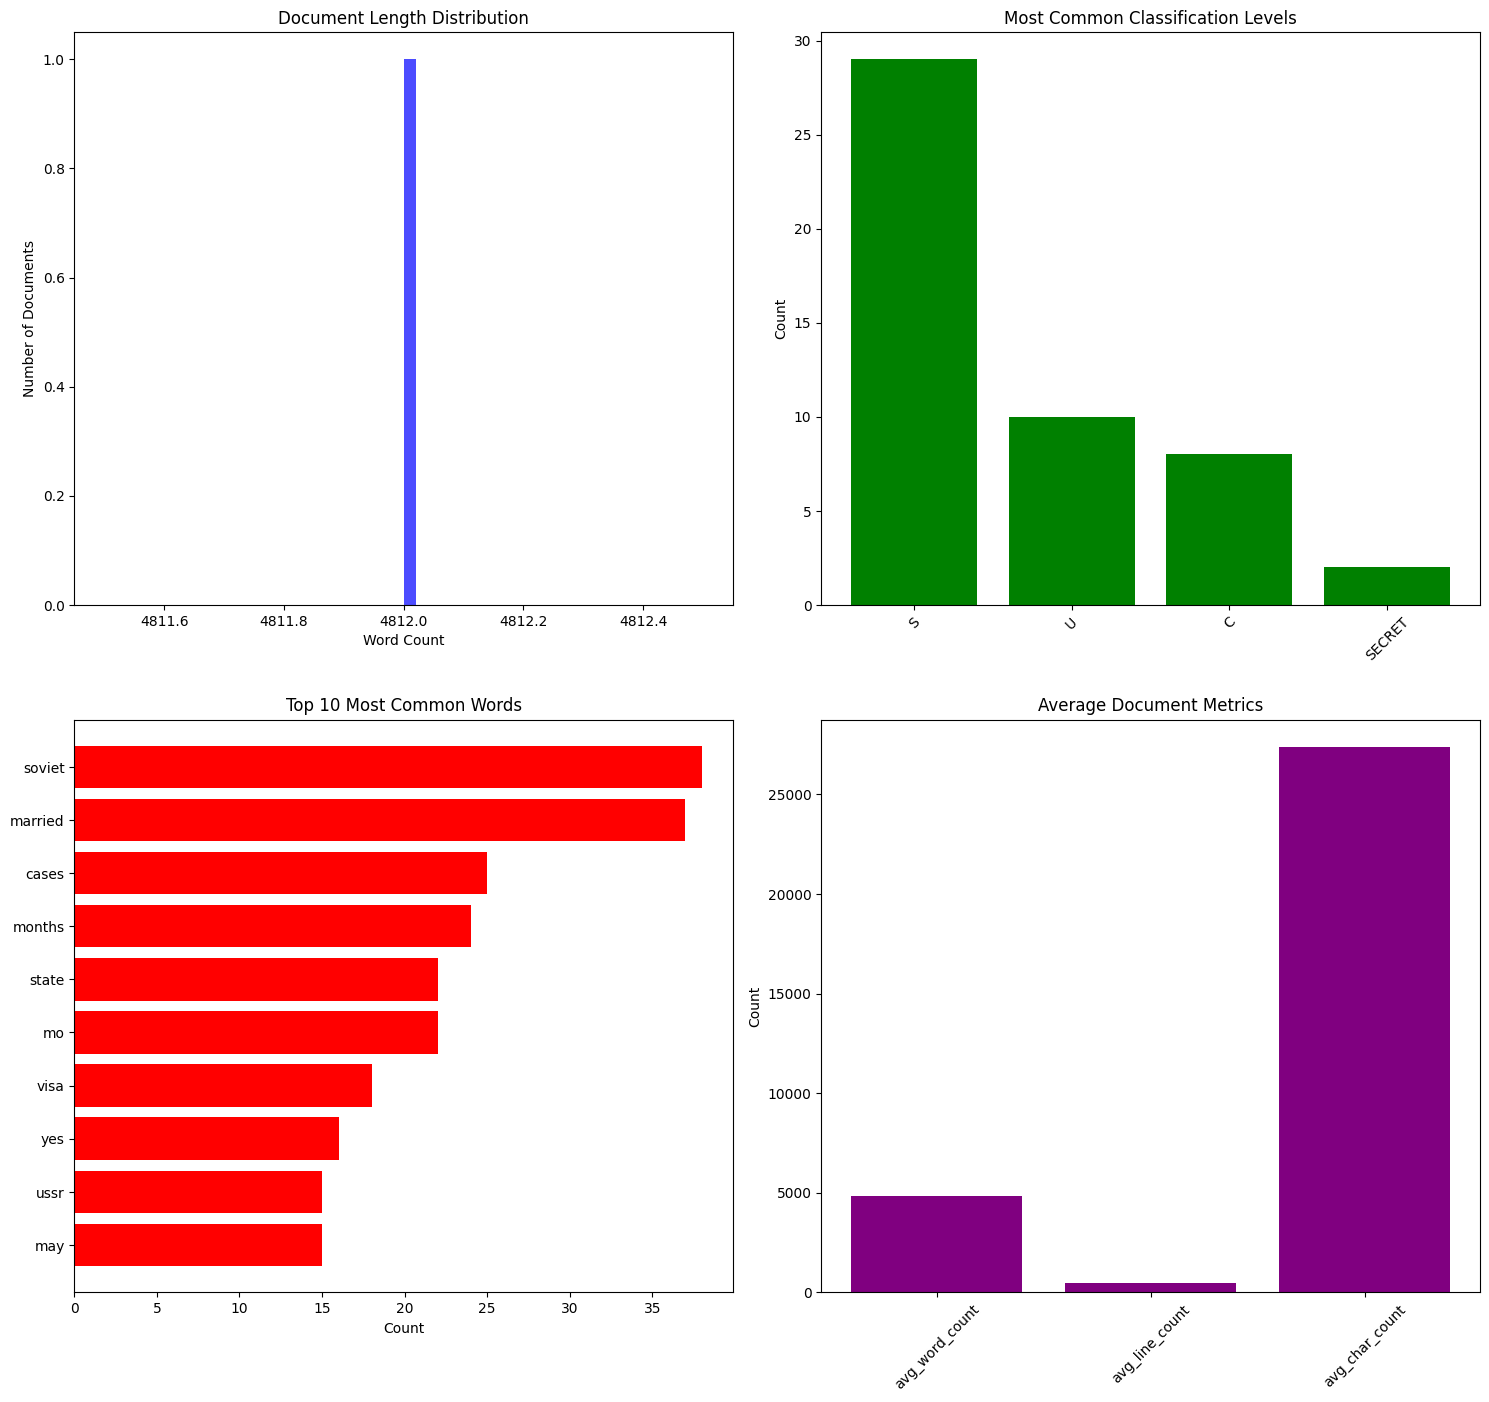

In [41]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import string
import nltk

# Explicitly download only stopwords
try:
    nltk.download('stopwords')
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
    USE_NLTK = True
    print("Successfully loaded NLTK stopwords")
except Exception as e:
    print(f"Warning: Failed to download NLTK resources: {e}")
    print("Will use basic tokenization without stopwords")
    USE_NLTK = False
    stop_words = set()  # Empty set instead of hardcoded stopwords

def analyze_jfk_documents(directory_path):
    """
    Analyze JFK document text files in the specified directory.

    Args:
        directory_path: Path to the directory containing OCR text files

    Returns:
        DataFrame with document statistics and metadata
    """
    # Initialize data collection
    doc_stats = []
    all_words = []
    classification_counts = Counter()
    date_mentions = []

    # Common classification patterns
    classification_patterns = [
        r'\b(?:TOP\s*SECRET|SECRET|CONFIDENTIAL|UNCLASSIFIED)\b',
        r'\b(?:TS|S|C|U)\b'  # Abbreviations
    ]

    # Date patterns (various formats)
    date_patterns = [
        r'\b\d{1,2}[/-]\d{1,2}[/-]\d{2,4}\b',  # MM/DD/YYYY or DD/MM/YYYY
        r'\b(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*\s+\d{1,2},?\s+\d{4}\b'  # Month DD, YYYY
    ]

    # Process each file
    file_count = 0
    for filename in os.listdir(directory_path):
        if filename.endswith('.txt'):
            file_path = os.path.join(directory_path, filename)
            file_count += 1

            try:
                with open(file_path, 'r', encoding='utf-8', errors='replace') as file:
                    content = file.read()

                    # Basic statistics - using simple split instead of punkt
                    words = content.split()
                    word_count = len(words)
                    line_count = len(content.split('\n'))
                    char_count = len(content)

                    # Extract words for frequency analysis (excluding stopwords and punctuation)
                    clean_words = []
                    for word in words:
                        # Remove punctuation
                        word = word.lower().strip(string.punctuation)
                        if word and word.isalpha():
                            # Only filter by stopwords if we have them
                            if not USE_NLTK or (USE_NLTK and word not in stop_words):
                                clean_words.append(word)
                    all_words.extend(clean_words)

                    # Find classification levels
                    classifications = []
                    for pattern in classification_patterns:
                        matches = re.findall(pattern, content, re.IGNORECASE)
                        if matches:
                            classifications.extend([m.upper() for m in matches])

                    if classifications:
                        classification_counts.update(classifications)

                    # Extract potential dates
                    dates = []
                    for pattern in date_patterns:
                        matches = re.findall(pattern, content)
                        if matches:
                            dates.extend(matches)
                    date_mentions.extend(dates)

                    # Store document statistics
                    doc_stats.append({
                        'filename': filename,
                        'word_count': word_count,
                        'line_count': line_count,
                        'char_count': char_count,
                        'classifications': '; '.join(set(classifications)) if classifications else 'None',
                        'dates_mentioned': '; '.join(set(dates)) if dates else 'None'
                    })

                    # Print progress every 100 files
                    if file_count % 100 == 0:
                        print(f"Processed {file_count} files...")

            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")

    # Create DataFrame with document statistics
    stats_df = pd.DataFrame(doc_stats)

    # Handle empty dataframe case
    if stats_df.empty:
        print("No files were processed successfully.")
        return pd.DataFrame(), {}

    # Get word frequency
    word_freq = Counter(all_words).most_common(100)

    # Generate summary
    summary = {
        'total_documents': file_count,
        'avg_word_count': stats_df['word_count'].mean() if 'word_count' in stats_df.columns else 0,
        'avg_line_count': stats_df['line_count'].mean() if 'line_count' in stats_df.columns else 0,
        'avg_char_count': stats_df['char_count'].mean() if 'char_count' in stats_df.columns else 0,
        'most_common_classifications': dict(classification_counts.most_common(5)),
        'most_common_words': dict(word_freq[:20]),
        'total_dates_found': len(date_mentions),
        'unique_dates_found': len(set(date_mentions))
    }

    return stats_df, summary

def visualize_results(stats_df, summary):
    """
    Create visualizations of document analysis results.

    Args:
        stats_df: DataFrame with document statistics
        summary: Dictionary with summary statistics
    """
    # Check if we have data to visualize
    if stats_df.empty:
        print("No data to visualize.")
        return

    # Set up the figure for multiple plots
    plt.figure(figsize=(15, 20))

    # 1. Document length distribution
    plt.subplot(3, 2, 1)
    plt.hist(stats_df['word_count'], bins=50, alpha=0.7, color='blue')
    plt.title('Document Length Distribution')
    plt.xlabel('Word Count')
    plt.ylabel('Number of Documents')

    # 2. Top classifications
    plt.subplot(3, 2, 2)
    classifications = summary['most_common_classifications']
    if classifications:
        plt.bar(list(classifications.keys()), list(classifications.values()), color='green')
        plt.title('Most Common Classification Levels')
        plt.xticks(rotation=45)
        plt.ylabel('Count')
    else:
        plt.text(0.5, 0.5, 'No classification data found', ha='center', va='center')
        plt.title('Most Common Classification Levels')

    # 3. Top words
    plt.subplot(3, 2, 3)
    words = summary['most_common_words']
    if words:
        keys = list(words.keys())[:10]  # Limit to top 10 for readability
        values = [words[k] for k in keys]
        plt.barh(list(reversed(keys)), list(reversed(values)), color='red')
        plt.title('Top 10 Most Common Words')
        plt.xlabel('Count')
    else:
        plt.text(0.5, 0.5, 'No word frequency data found', ha='center', va='center')
        plt.title('Most Common Words')

    # 4. Document statistics
    plt.subplot(3, 2, 4)
    metrics = ['avg_word_count', 'avg_line_count', 'avg_char_count']
    values = [summary[m] for m in metrics]
    plt.bar(metrics, values, color='purple')
    plt.title('Average Document Metrics')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

    # Save the figure
    plt.tight_layout()
    plt.savefig('jfk_document_analysis.png')
    print("Visualizations saved to 'jfk_document_analysis.png'")

    # Export data to CSV
    stats_df.to_csv('jfk_document_statistics.csv', index=False)
    print("Document statistics saved to 'jfk_document_statistics.csv'")

if __name__ == "__main__":
    # Set the directory containing JFK document text files
    directory_path = "ocr_results/text"  # Fixed path based on error message

    print(f"Starting analysis of files in {directory_path}...")
    stats_df, summary = analyze_jfk_documents(directory_path)

    # Print summary
    if summary:
        print("\nAnalysis Summary:")
        for key, value in summary.items():
            if isinstance(value, dict):
                print(f"\n{key}:")
                for k, v in value.items():
                    print(f"  {k}: {v}")
            else:
                print(f"{key}: {value}")

        # Create visualizations
        visualize_results(stats_df, summary)

        print("\nAnalysis complete!")
    else:
        print("Analysis failed: No data was processed successfully.")

## Create Index in Pinecone

I used Pinecone for this exercise for speed but recommend you check out alternatives like pg_vector for vector search (with the benefit of using a relational db).

In [15]:
from pinecone import Pinecone

# Initialize a Pinecone client with your API key
api_key = "YOUR_PINECONE_API_KEY"
pc = Pinecone(api_key=api_key)

Source: https://docs.pinecone.io/guides/indexes/create-an-index
There are two main ways to search: lexical or semantic.

Lexical is closer to keyword matching (like "Oswald" or "shooter")

Semantic tries to pull results based on meaning

For this exercise, I used lexical search because users will likely hunt for specific terms in the files. Hybrid search (mixing both) works best in production, but keyword matching makes sense here.

In [16]:
# Create a sparse index with integrated embedding
index_name = "jfk-index"

if not pc.has_index(name=index_name):
    pc.create_index_for_model(
        name=index_name,
        cloud="aws",
        region="us-east-1",
        embed={
            "model":"pinecone-sparse-english-v0",
            "field_map":{"text": "chunk_text"}
        }
    )

Wait ten seconds so your index can be initialized before inserting records.

In [44]:
import time

time.sleep(10)

We use a naive chunking strategy of simply chopping up files into 512 character blocks. You probably want to do something more robust like context aware chunking in real life.

In [22]:
import os
import time
import shutil
from tqdm import tqdm

namespace = "jfk-namespace"  # Namespace for the index
folder_path = "ocr_results/text"  # Directory containing text files
max_tokens = 512  # Maximum tokens per chunk
batch_size = 96  # Batch size for upsert (not used in single record test)
delay_seconds = 2.0  # Delay between batches (not used in single record test)

# Get Index client
sparse_index = pc.Index(name=index_name)

def chunk_text(text, max_tokens=max_tokens):
    """Split text into chunks of approximately max_tokens"""
    words = text.split()
    chunks = []
    current_chunk = []
    current_token_count = 0

    for word in words:
        if current_token_count + 1 > max_tokens:
            chunks.append(" ".join(current_chunk))
            current_chunk = [word]
            current_token_count = 1
        else:
            current_chunk.append(word)
            current_token_count += 1

    if current_chunk:
        chunks.append(" ".join(current_chunk))

    return chunks

# Count total files for progress tracking
total_files = len([f for f in os.listdir(folder_path) if f.endswith('.txt')])
print(f"Found {total_files} text files to process")

# Initialize an empty list to store our records
records = []

# Loop through all files in the folder with progress bar
for i, filename in enumerate(tqdm(
    [f for f in os.listdir(folder_path) if f.endswith('.txt')],
    desc="Processing files"
)):
    file_path = os.path.join(folder_path, filename)
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read().strip()
            chunks = chunk_text(content, max_tokens=max_tokens)

            # Only process the first chunk of the first file for testing
            if i == 0 and chunks:
                record = {
                    "_id": f"{filename.replace('.txt', '')}_0",
                    "chunk_text": chunks[0],
                    "filename": filename
                }
                records.append(record)
                break  # Exit after processing the first chunk of the first file

    except Exception as e:
        print(f"Error processing {filename}: {str(e)}")

# Print summary before uploading
print(f"\nProcessed {total_files} files into {len(records)} total chunks")

# Check if there are any records to upload
if not records:
    print("No records to upload. Exiting.")
    exit()

# Get current count in namespace
try:
    stats = sparse_index.describe_index_stats()
    current_count = stats.get('namespaces', {}).get(namespace, {}).get('vector_count', 0)
    print(f"Current record count in namespace '{namespace}': {current_count}")
except Exception as e:
    print(f"Could not get current record count: {str(e)}")
    current_count = 0

# Upsert the single record
try:
    sparse_index.upsert_records(
        namespace=namespace,
        records=records
    )
    print(f"✓ Upserted 1 record successfully")
except Exception as e:
    print(f"✗ Error upserting record: {str(e)}")

print(f"\nTotal records upserted to {namespace}: {len(records)}")

# Print stats by filename
print("\nChunks per file:")
filename_stats = {}
for r in records:
    filename = r["filename"]
    if filename not in filename_stats:
        filename_stats[filename] = 0
    filename_stats[filename] += 1

for filename, count in sorted(filename_stats.items()):
    print(f"{filename}: {count} chunks")

Found 1 text files to process


Processing files:   0%|          | 0/1 [00:00<?, ?it/s]


Processed 1 files into 1 total chunks


Current record count in namespace 'jfk-namespace': 1
✓ Upserted 1 record successfully

Total records upserted to jfk-namespace: 1

Chunks per file:
104-10004-10213.txt: 1 chunks


In [42]:
  # get stats for your index
  final_stats = sparse_index.describe_index_stats()
  final_count = final_stats.get('namespaces', {}).get(namespace, {}).get('vector_count', 0)
  print(f"\nFinal record count in namespace '{namespace}': {final_count}")



Final record count in namespace 'jfk-namespace': 1


## Query Index

In [34]:
results = sparse_index.search_records(
    namespace=namespace,
    query={
        "inputs": {"text": "Soviet"},
        "top_k": 3
    },
    fields=["chunk_text", "filename"]
)

print(results)

{'result': {'hits': [{'_id': '104-10004-10213_0',
                      '_score': 3.408203125,
                      'fields': {'chunk_text': '# SECRET ## YAP. 27221 9 July '
                                               '1964 ## MEMORANDUM FOR THE '
                                               'RECORD David Slawson of the '
                                               "staff of the President's "
                                               'Commission on the '
                                               'Assassination of President '
                                               'Kennedy at 1400 hours on this '
                                               "date in the Commission's "
                                               'offices at 200 Maryland '
                                               'Avenue, N.E., Washington, D.C. '
                                               'The purpose of this meeting '
                                               'was to discuss